In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(1)

In [3]:
def make_dag(layers):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    num_nodes_prev = 0
    for i, layer_size in enumerate(layers):
        if i == 0:
            for b in range(layer_size):
                g.add_edge(0, 1+b)
        else:
            prev_layer_size = layers[i - 1]
            for a in range(prev_layer_size):
                for b in range(layer_size):
                    g.add_edge(num_nodes_prev+a, num_nodes+b)
        num_nodes_prev = num_nodes
        num_nodes += layer_size
    g.graph["root"] = 0
    return g

In [4]:
def make_tree(branching_factors):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    nodes_prev_layer = [0]
    for i, factor in enumerate(branching_factors):
        nodes_current_layer = []
        for n in nodes_prev_layer:
            for c in range(factor):
                g.add_edge(n, num_nodes)
                nodes_current_layer.append(num_nodes)
                num_nodes += 1
        nodes_prev_layer = nodes_current_layer
    g.graph["root"] = 0
    return g

In [5]:
num_docs = 5000
words_per_doc = 20
vocab_size = 10

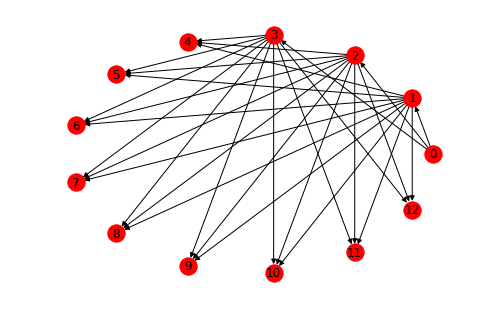

In [6]:
g = make_dag([3, 9])
nx.draw_circular(g, with_labels=True)

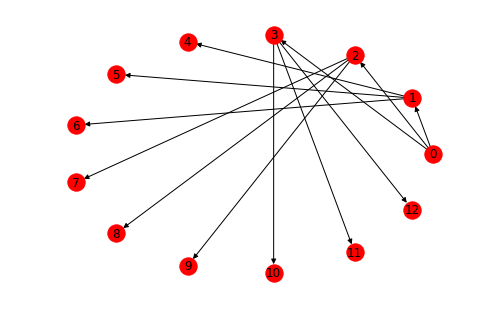

In [7]:
t = make_tree([3, 3])
nx.draw_circular(t, with_labels=True)

In [8]:
def successors(g, node):
    return list(g.successors(node))

def depth(g):
    return nx.algorithms.dag_longest_path_length(g)

In [9]:
class PAMSampler(object):
    def __init__(self, g, num_docs, words_per_doc, vocab_size):
        self.g = g
        self.num_docs = num_docs
        self.words_per_doc = words_per_doc
        self.vocab_size = vocab_size
        
    def sample(self):
        self.thetas_by_doc = []
        self.docs = []
        self.doc_nodes = []
        # Sample topics
        self.topics = dict()
        for node in self.g.nodes():
            nc = len(list(self.g.successors(node)))
            if nc == 0:
                self.topics[node] = np.random.dirichlet(np.ones(self.vocab_size))
        # Sample documents
        for i in tqdm(range(num_docs)):
            thetas = dict()
            for node in self.g.nodes():
                nc = len(list(self.g.successors(node)))
                if nc > 0:
                    alpha = np.ones(nc)
                    thetas[node] = np.random.dirichlet(alpha)
            self.thetas_by_doc.append(thetas)
            current_doc = []
            current_doc_nodes = []
            for j in range(words_per_doc):
                node = self.sample_leaf(thetas)
                current_doc_nodes.append(node)
                word_index = np.random.choice(self.vocab_size, p=self.topics[node])
                current_doc.append(word_index)
            self.docs.append(current_doc)
            self.doc_nodes.append(current_doc_nodes)
        return self
    
    def sample_leaf(self, thetas):
        current = self.g.graph["root"]
        options = successors(self.g, current)
        while len(options) > 0:
            current = options[np.random.choice(len(options), p=thetas[current])]
            options = successors(self.g, current)
        return current

In [10]:
class HPAM1Sampler(object):
    def __init__(self, g, num_docs, words_per_doc, vocab_size):
        self.g = g
        self.num_docs = num_docs
        self.words_per_doc = words_per_doc
        self.vocab_size = vocab_size
        
    def sample(self):
        self.thetas_by_doc = []
        self.docs = []
        self.doc_paths = []
        self.doc_nodes = []
        # Sample topics
        self.topics = dict()
        for node in self.g.nodes():
            self.topics[node] = np.random.dirichlet(np.ones(self.vocab_size))
        # Sample documents
        for i in tqdm(range(num_docs)):
            thetas = dict()
            for node in self.g.nodes():
                nc = len(list(self.g.successors(node)))
                if nc > 0:
                    alpha = np.ones(nc)
                    thetas[node] = np.random.dirichlet(alpha)
            self.thetas_by_doc.append(thetas)
            current_doc = []
            current_doc_paths = []
            current_doc_nodes = []
            for j in range(words_per_doc):
                path = self.sample_leaf_path(thetas)
                current_doc_paths.append(path)
                # NOTE: assuming zeta_{path} is the same for all paths
                depth_distrib = np.ones(len(path)) / float(len(path))
                node = np.random.choice(path, p=depth_distrib)
                current_doc_nodes.append(node)
                word_index = np.random.choice(self.vocab_size, p=self.topics[node])
                current_doc.append(word_index)
            self.docs.append(current_doc)
            self.doc_paths.append(current_doc_paths)
            self.doc_nodes.append(current_doc_nodes)
        return self
    
    def sample_leaf_path(self, thetas):
        path = []
        current = self.g.graph["root"]
        options = successors(self.g, current)
        path.append(current)
        while len(options) > 0:
            current = options[np.random.choice(len(options), p=thetas[current])]
            options = successors(self.g, current)
            path.append(current)
        return path

In [11]:
class HPAM2Sampler(object):
    def __init__(self, g, num_docs, words_per_doc, vocab_size):
        self.g = g
        self.num_docs = num_docs
        self.words_per_doc = words_per_doc
        self.vocab_size = vocab_size
        
    def sample(self):
        self.thetas_by_doc = []
        self.docs = []
        self.doc_nodes = []
        # Sample topics
        self.topics = dict()
        for node in self.g.nodes():
            self.topics[node] = np.random.dirichlet(np.ones(self.vocab_size))
        # Sample documents
        for i in tqdm(range(num_docs)):
            thetas = dict()
            for node in self.g.nodes():
                nc = len(list(self.g.successors(node)))
                if nc > 0:
                    alpha = np.ones(nc + 1)
                    thetas[node] = np.random.dirichlet(alpha)
            self.thetas_by_doc.append(thetas)
            current_doc = []
            current_doc_nodes = []
            for j in range(words_per_doc):
                node = self.sample_node(thetas)
                current_doc_nodes.append(node)
                word_index = np.random.choice(self.vocab_size, p=self.topics[node])
                current_doc.append(word_index)
            self.docs.append(current_doc)
            self.doc_nodes.append(current_doc_nodes)
        return self
    
    def sample_node(self, thetas):
        current = self.g.graph["root"]
        options = successors(self.g, current)
        while len(options) > 0:
            assert len(thetas[current] == len(options) + 1)
            choice = np.random.choice(len(thetas[current]), p=thetas[current])
            if choice == 0:
                return current
            current = options[choice - 1]
            options = successors(self.g, current)
        return current

In [12]:
def coocurrence(sampler):
    num_nodes = np.max(sampler.doc_nodes) + 1
    counts = np.zeros((num_nodes, num_nodes))
    for current_dn in sampler.doc_nodes:
        for i in range(len(current_dn) // 2):
            topic0 = current_dn[2 * i + 0]
            topic1 = current_dn[2 * i + 1]
            counts[topic0, topic1] += 1
    return counts / np.sum(counts)

In [13]:
def niceimshow(X, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(X, **kwargs)
    ax.axis('off')

In [14]:
graphs = [("Tree", t), ("DAG", g)]
sampler_types = [PAMSampler, HPAM1Sampler, HPAM2Sampler]

In [15]:
samplers = dict()
for graph_name, graph in graphs:
    samplers[graph_name] = dict()
    for s in sampler_types:
        sampler_name = s.__name__
        result = s(graph, num_docs, words_per_doc, vocab_size).sample()
        samplers[graph_name][sampler_name] = result

100%|██████████| 5000/5000 [00:10<00:00, 465.60it/s]


In [16]:
cooccurrence_matrices = dict()
for graph_name, graph in graphs:
    cooccurrence_matrices[graph_name] = dict()
    for sampler_name, result in samplers[graph_name].items():
        m = coocurrence(result)
        cooccurrence_matrices[graph_name][sampler_name] = m

In [17]:
def nicesubplots(rows, cols, scale=4, **kwargs):
    dims = np.array([rows, cols])
    return plt.subplots(*dims, figsize = dims[::-1] * scale, **kwargs)

In [18]:
def without_diag(X):
    return X - np.diag(np.diag(X))

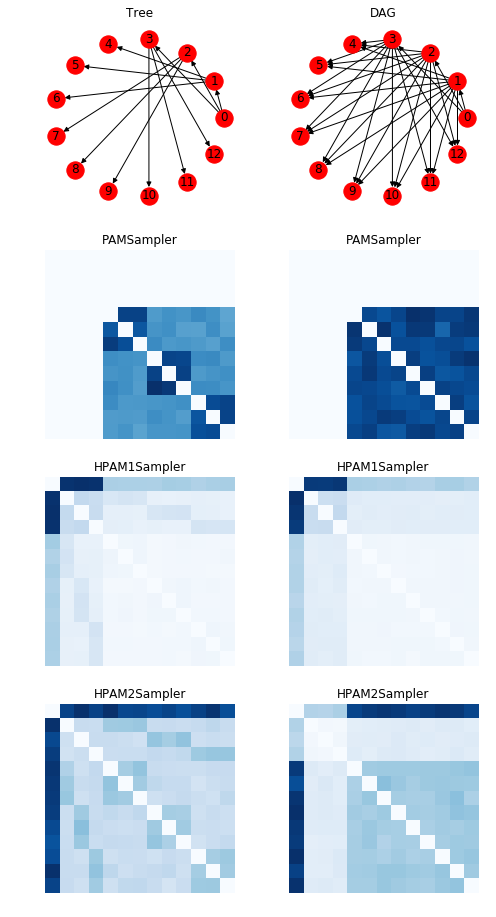

In [19]:
fig, axes = nicesubplots(len(sampler_types) + 1, len(graphs))
for i, (graph_name, graph) in enumerate(graphs):
    nx.draw_circular(graph, with_labels=True, ax=axes[0,i])
    axes[0,i].set_title(graph_name)
    for j, (sampler_name, m) in enumerate(cooccurrence_matrices[graph_name].items()):
        ax = axes[j+1,i]
        niceimshow(without_diag(m), ax = ax, cmap='Blues')  #, vmin=0, vmax=1)
        ax.set_title(sampler_name)